In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, re
import seaborn as sns
from scipy import stats

# load the data
dfs = []

df = pd.read_csv("rba-dataset.csv")
print(f"Loaded {len(df)} rows.")

Loaded 31269264 rows.


In [7]:
# find missing values
df.isna().sum()

index                              0
Login Timestamp                    0
User ID                            0
Round-Trip Time [ms]        29993329
IP Address                         0
Country                            0
Region                         47409
City                            8590
ASN                                0
User Agent String                  0
Browser Name and Version           0
OS Name and Version                0
Device Type                     1526
Login Successful                   0
Is Attack IP                       0
Is Account Takeover                0
dtype: int64

In [8]:
# drop RTT column and omit rows with missing Region, City or Device Type
df = df.drop(columns=["Round-Trip Time [ms]", "index", "Region", "City"], errors='ignore')
df = df.dropna(subset=["Device Type"])

Country
US       2416773
NO        159391
PL         93303
ID         70129
RO         60340
Other     296598
Name: count, dtype: int64


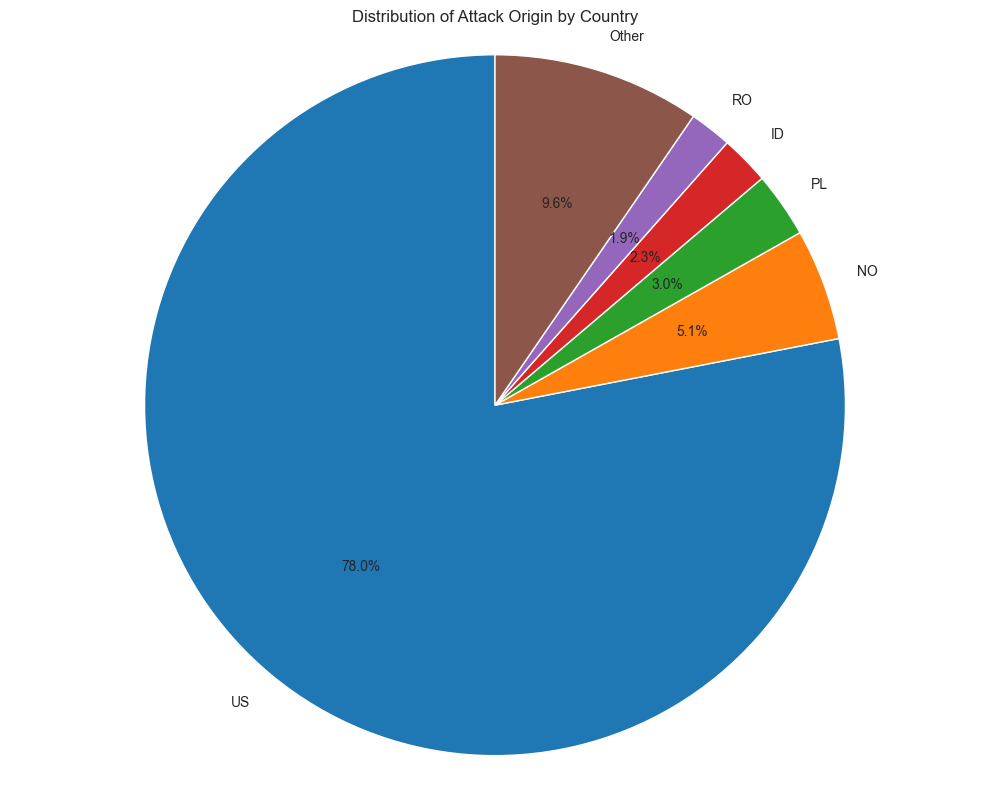

In [20]:
# Figure 1: pie chart of geographical locations when attack is true
attacked_df = df[df['Is Attack IP'] | df['Is Account Takeover']]
country_counts = attacked_df['Country'].value_counts()
top_n = 5
if len(country_counts) > top_n:
    other_count = country_counts[top_n:].sum()
    country_counts = country_counts[:top_n]
    country_counts['Other'] = other_count

# print the top 5 countries
print(country_counts)

# create pie chart
plt.figure(figsize=(10, 8))
plt.pie(country_counts, labels=country_counts.index, autopct='%1.1f%%',  
        shadow=False, startangle=90)
plt.axis('equal')
plt.title('Distribution of Attack Origin by Country')
plt.tight_layout()

plt.savefig('attack_countries_pie.png', dpi=300, bbox_inches='tight')

plt.show()

In [10]:
# clean version data
def clean(name):
    return re.sub(r'\s*\d+(\.\d+)*.*$', '', name)

df['Browser Name and Version'] = df['Browser Name and Version'].apply(clean)
df['OS Name and Version'] = df['OS Name and Version'].apply(clean)
df.head()

,Login Timestamp,User ID,IP Address,Country,ASN,User Agent String,Browser Name and Version,OS Name and Version,Device Type,Login Successful,Is Attack IP,Is Account Takeover
0,2020-02-03 12:43:30.772,-4324475583306591935,10.0.65.171,NO,29695,Mozilla/5.0 (iPhone; CPU iPhone OS 13_4 like ...,Firefox,iOS,mobile,False,False,False
1,2020-02-03 12:43:43.549,-4324475583306591935,194.87.207.6,AU,60117,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile,Android,mobile,False,False,False
2,2020-02-03 12:43:55.873,-3284137479262433373,81.167.144.58,NO,29695,Mozilla/5.0 (iPad; CPU OS 7_1 like Mac OS X) ...,Android,iOS,mobile,True,False,False
3,2020-02-03 12:43:56.180,-4324475583306591935,170.39.78.152,US,393398,Mozilla/5.0 (Linux; Android 4.1; Galaxy Nexus...,Chrome Mobile WebView,Android,mobile,False,False,False
4,2020-02-03 12:43:59.396,-4618854071942621186,10.0.0.47,US,398986,Mozilla/5.0 (Linux; U; Android 2.2) Build/NMA...,Chrome Mobile WebView,Android,mobile,False,True,False


C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\2402980803.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  successful_top['Environment'] = successful_top.apply(
C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\2402980803.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(x='Count', y='Environment', data=successful_top, palette='viridis')


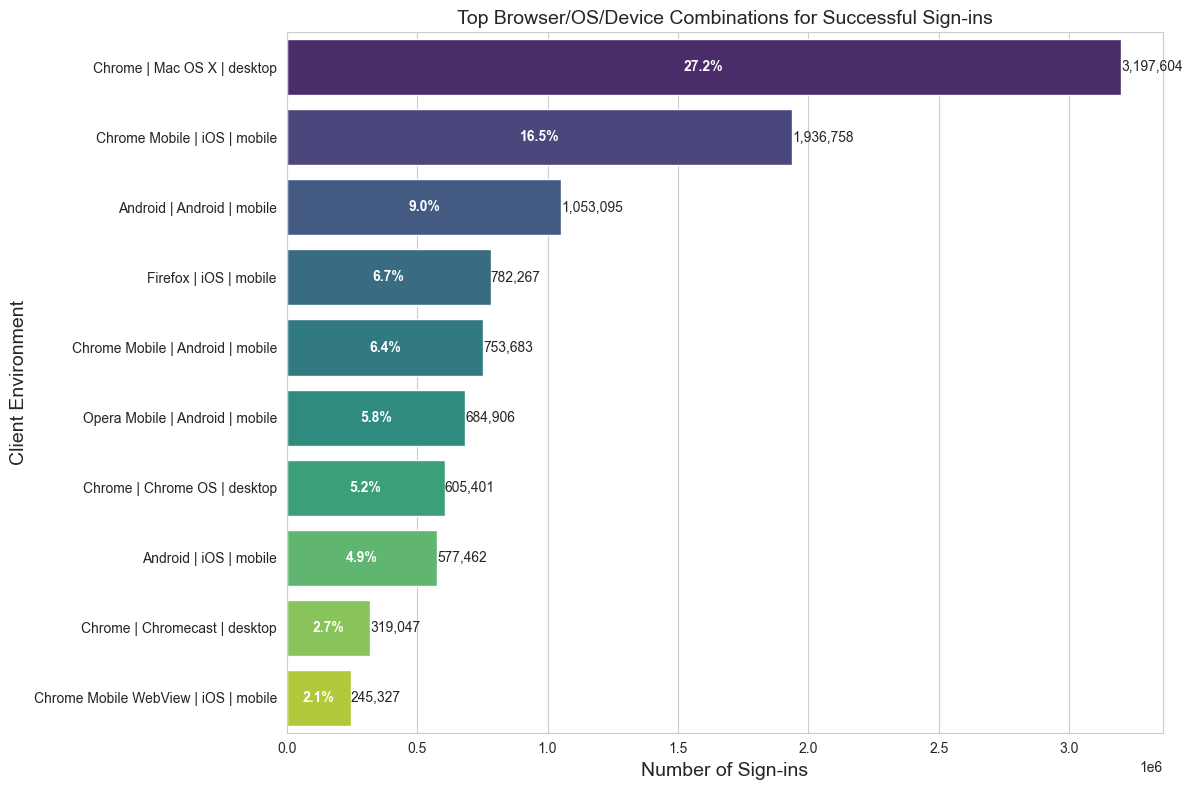

C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\2402980803.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  malicious_top['Environment'] = malicious_top.apply(
C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\2402980803.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax2 = sns.barplot(x='Count', y='Environment', data=malicious_top, palette='viridis')


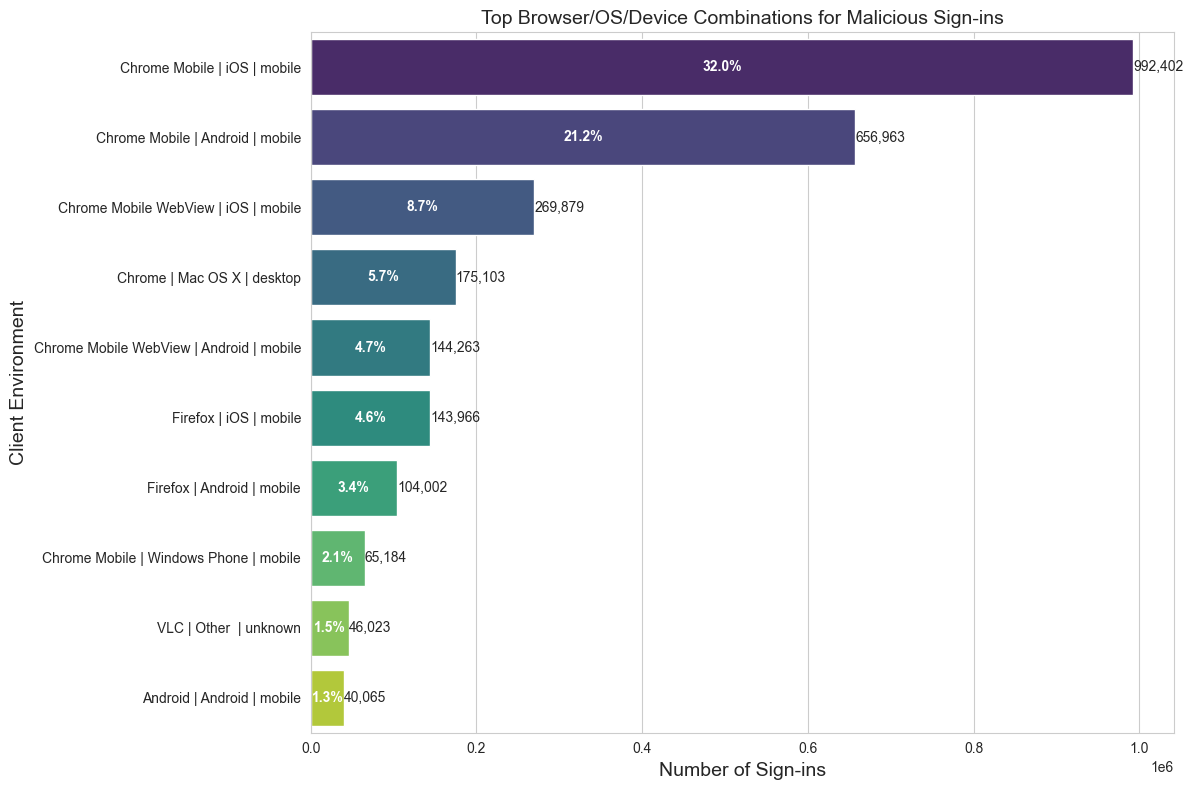

In [22]:
# Figure 4: bar chart of legitimate logins by client enviroment combination
plt.figure(figsize=(12, 8))

# data preparation for successful logins
successful_logins = df[(df['Login Successful'] == True) & (df['Is Attack IP'] == False) & 
                     (df['Is Account Takeover'] == False)]
successful_grouped = successful_logins.groupby(['Browser Name and Version', 'OS Name and Version', 
                                            'Device Type']).size().reset_index(name='Count')
successful_grouped = successful_grouped.sort_values('Count', ascending=False)

# top 10 combinations
successful_top = successful_grouped.head(10)
successful_top['Environment'] = successful_top.apply(
    lambda row: f"{row['Browser Name and Version']} | {row['OS Name and Version']} | {row['Device Type']}", axis=1)

ax1 = sns.barplot(x='Count', y='Environment', data=successful_top, palette='viridis')

# add labels
for i, v in enumerate(successful_top['Count']):
    ax1.text(v + 0.1, i, f"{v:,}", va='center')

for i, v in enumerate(successful_top['Count']):
    percentage = (v / successful_grouped['Count'].sum()) * 100
    ax1.text(v/2, i, f"{percentage:.1f}%", va='center', ha='center', color='white', fontweight='bold')

plt.title('Top Browser/OS/Device Combinations for Successful Sign-ins', fontsize=14)
plt.xlabel('Number of Sign-ins', fontsize=14)
plt.ylabel('Client Environment', fontsize=14)
plt.tight_layout()
plt.savefig('successful_client_environment.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 5: bar chart of malicious logins by client enviroment combination 
plt.figure(figsize=(12, 8))

# data preparation for malicious logins
malicious_logins = df[((df['Is Attack IP'] == True) | (df['Is Account Takeover'] == True))]
malicious_grouped = malicious_logins.groupby(['Browser Name and Version', 'OS Name and Version', 
                                          'Device Type']).size().reset_index(name='Count')
malicious_grouped = malicious_grouped.sort_values('Count', ascending=False)

# top 10 combinations
malicious_top = malicious_grouped.head(10)
malicious_top['Environment'] = malicious_top.apply(
    lambda row: f"{row['Browser Name and Version']} | {row['OS Name and Version']} | {row['Device Type']}", axis=1)

ax2 = sns.barplot(x='Count', y='Environment', data=malicious_top, palette='viridis')

# add labels
for i, v in enumerate(malicious_top['Count']):
    ax2.text(v + 0.1, i, f"{v:,}", va='center')

for i, v in enumerate(malicious_top['Count']):
    percentage = (v / malicious_grouped['Count'].sum()) * 100
    ax2.text(v/2, i, f"{percentage:.1f}%", va='center', ha='center', color='white', fontweight='bold')

plt.title('Top Browser/OS/Device Combinations for Malicious Sign-ins', fontsize=14)
plt.xlabel('Number of Sign-ins', fontsize=14)
plt.ylabel('Client Environment', fontsize=14)
plt.tight_layout()
plt.savefig('malicious_client_environment.png', dpi=300, bbox_inches='tight')
plt.show()

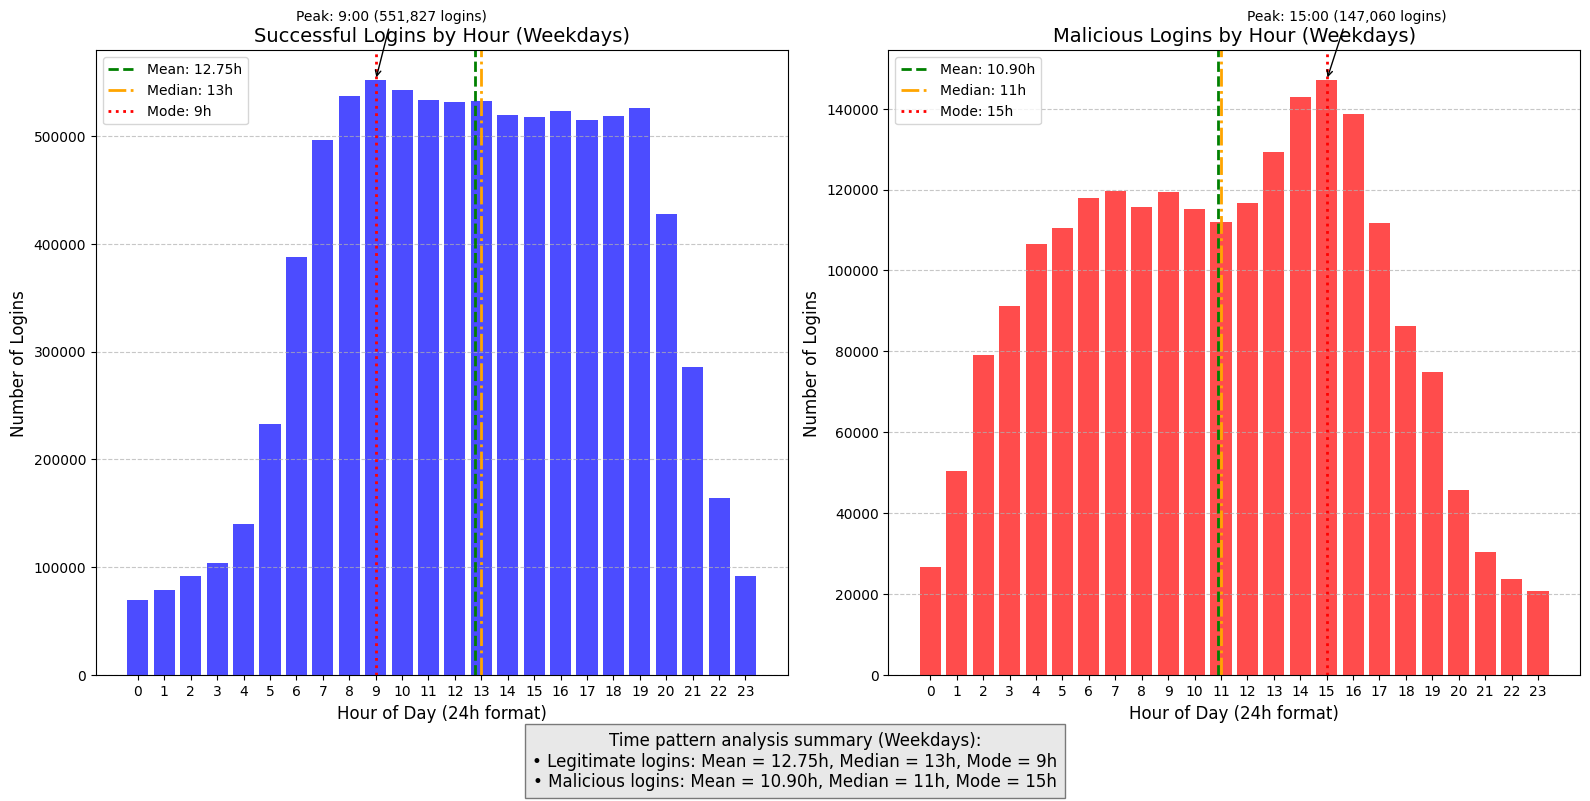

In [12]:
# Figure 3: successful and malicious logins by hour on weekdays
# convert timestamp and extract hour and weekday
df['Login Timestamp'] = pd.to_datetime(df['Login Timestamp'])
df['Hour'] = df['Login Timestamp'].dt.hour
df['Weekday'] = df['Login Timestamp'].dt.dayofweek  # 0=Monday, 1=Tuesday, ..., 6=Sunday

# filter for weekdays only (Monday=0 through Friday=4)
weekday_df = df[df['Weekday'] <= 4]

successful_logins_by_hour = weekday_df[(weekday_df['Login Successful'] == True) & 
                                      (weekday_df['Is Attack IP'] == False) & 
                                      (weekday_df['Is Account Takeover'] == False)].groupby('Hour').size().reset_index(name='Count')

malicious_logins_by_hour = weekday_df[((weekday_df['Is Attack IP'] == True) | 
                                     (weekday_df['Is Account Takeover'] == True))].groupby('Hour').size().reset_index(name='Count')

success_mean = np.average(successful_logins_by_hour['Hour'], weights=successful_logins_by_hour['Count'])
success_median = np.median(np.repeat(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count']))
success_mode = stats.mode(np.repeat(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count'])).mode

malicious_mean = np.average(malicious_logins_by_hour['Hour'], weights=malicious_logins_by_hour['Count'])
malicious_median = np.median(np.repeat(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count']))
malicious_mode = stats.mode(np.repeat(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count'])).mode

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.bar(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count'], color='blue', alpha=0.7)
plt.axvline(x=success_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {success_mean:.2f}h')
plt.axvline(x=success_median, color='orange', linestyle='-.', linewidth=2, label=f'Median: {success_median:.0f}h')
plt.axvline(x=success_mode, color='red', linestyle=':', linewidth=2, label=f'Mode: {success_mode:.0f}h')

plt.title('Successful Logins by Hour (Weekdays)', fontsize=14)
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('Number of Logins', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

peak_hour = successful_logins_by_hour.loc[successful_logins_by_hour['Count'].idxmax()]
plt.annotate(f'Peak: {peak_hour["Hour"]}:00 ({peak_hour["Count"]:,} logins)', 
             xy=(peak_hour["Hour"], peak_hour["Count"]),
             xytext=(peak_hour["Hour"]-3, peak_hour["Count"]*1.1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.subplot(1, 2, 2)
plt.bar(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count'], color='red', alpha=0.7)
plt.axvline(x=malicious_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {malicious_mean:.2f}h')
plt.axvline(x=malicious_median, color='orange', linestyle='-.', linewidth=2, label=f'Median: {malicious_median:.0f}h')
plt.axvline(x=malicious_mode, color='red', linestyle=':', linewidth=2, label=f'Mode: {malicious_mode:.0f}h')

plt.title('Malicious Logins by Hour (Weekdays)', fontsize=14)
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('Number of Logins', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

peak_hour_mal = malicious_logins_by_hour.loc[malicious_logins_by_hour['Count'].idxmax()]
plt.annotate(f'Peak: {peak_hour_mal["Hour"]}:00 ({peak_hour_mal["Count"]:,} logins)', 
             xy=(peak_hour_mal["Hour"], peak_hour_mal["Count"]),
             xytext=(peak_hour_mal["Hour"]-3, peak_hour_mal["Count"]*1.1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.figtext(0.5, 0.01, 
           f"Time pattern analysis summary (Weekdays):\n"
           f"• Legitimate logins: Mean = {success_mean:.2f}h, Median = {success_median:.0f}h, Mode = {success_mode:.0f}h\n"
           f"• Malicious logins: Mean = {malicious_mean:.2f}h, Median = {malicious_median:.0f}h, Mode = {malicious_mode:.0f}h",
           ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15) 

plt.savefig('weekdays_login_by_hour_with_central_tendency.png', dpi=300, bbox_inches='tight')
plt.show()

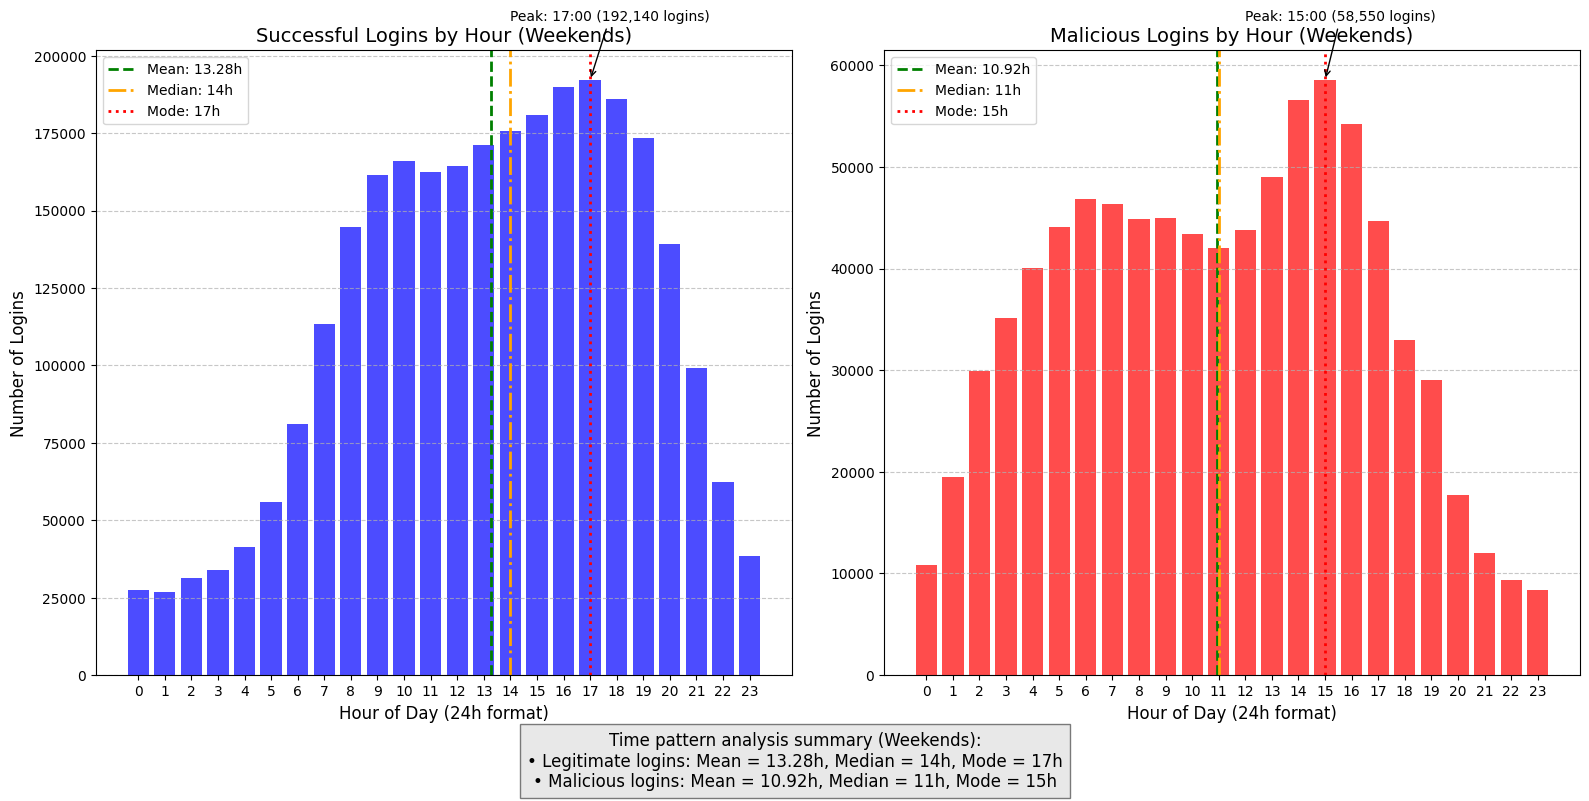

In [13]:
# Figure 4: successful and malicious logins by hour on weekends

df['Login Timestamp'] = pd.to_datetime(df['Login Timestamp'])
df['Hour'] = df['Login Timestamp'].dt.hour
df['Weekday'] = df['Login Timestamp'].dt.dayofweek 

# filter for weekends only (Saturday=5, Sunday=6)
weekend_df = df[df['Weekday'] >= 5]

successful_logins_by_hour = weekend_df[(weekend_df['Login Successful'] == True) & 
                                      (weekend_df['Is Attack IP'] == False) & 
                                      (weekend_df['Is Account Takeover'] == False)].groupby('Hour').size().reset_index(name='Count')

malicious_logins_by_hour = weekend_df[((weekend_df['Is Attack IP'] == True) | 
                                     (weekend_df['Is Account Takeover'] == True))].groupby('Hour').size().reset_index(name='Count')

success_mean = np.average(successful_logins_by_hour['Hour'], weights=successful_logins_by_hour['Count'])
success_median = np.median(np.repeat(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count']))
success_mode = stats.mode(np.repeat(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count'])).mode

malicious_mean = np.average(malicious_logins_by_hour['Hour'], weights=malicious_logins_by_hour['Count'])
malicious_median = np.median(np.repeat(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count']))
malicious_mode = stats.mode(np.repeat(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count'])).mode

plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.bar(successful_logins_by_hour['Hour'], successful_logins_by_hour['Count'], color='blue', alpha=0.7)
plt.axvline(x=success_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {success_mean:.2f}h')
plt.axvline(x=success_median, color='orange', linestyle='-.', linewidth=2, label=f'Median: {success_median:.0f}h')
plt.axvline(x=success_mode, color='red', linestyle=':', linewidth=2, label=f'Mode: {success_mode:.0f}h')

plt.title('Successful Logins by Hour (Weekends)', fontsize=14)
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('Number of Logins', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

peak_hour = successful_logins_by_hour.loc[successful_logins_by_hour['Count'].idxmax()]
plt.annotate(f'Peak: {peak_hour["Hour"]}:00 ({peak_hour["Count"]:,} logins)', 
             xy=(peak_hour["Hour"], peak_hour["Count"]),
             xytext=(peak_hour["Hour"]-3, peak_hour["Count"]*1.1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.subplot(1, 2, 2)
plt.bar(malicious_logins_by_hour['Hour'], malicious_logins_by_hour['Count'], color='red', alpha=0.7)
plt.axvline(x=malicious_mean, color='green', linestyle='--', linewidth=2, label=f'Mean: {malicious_mean:.2f}h')
plt.axvline(x=malicious_median, color='orange', linestyle='-.', linewidth=2, label=f'Median: {malicious_median:.0f}h')
plt.axvline(x=malicious_mode, color='red', linestyle=':', linewidth=2, label=f'Mode: {malicious_mode:.0f}h')

plt.title('Malicious Logins by Hour (Weekends)', fontsize=14)
plt.xlabel('Hour of Day (24h format)', fontsize=12)
plt.ylabel('Number of Logins', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

peak_hour_mal = malicious_logins_by_hour.loc[malicious_logins_by_hour['Count'].idxmax()]
plt.annotate(f'Peak: {peak_hour_mal["Hour"]}:00 ({peak_hour_mal["Count"]:,} logins)', 
             xy=(peak_hour_mal["Hour"], peak_hour_mal["Count"]),
             xytext=(peak_hour_mal["Hour"]-3, peak_hour_mal["Count"]*1.1),
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3", color='black'))

plt.figtext(0.5, 0.01, 
           f"Time pattern analysis summary (Weekends):\n"
           f"• Legitimate logins: Mean = {success_mean:.2f}h, Median = {success_median:.0f}h, Mode = {success_mode:.0f}h\n"
           f"• Malicious logins: Mean = {malicious_mean:.2f}h, Median = {malicious_median:.0f}h, Mode = {malicious_mode:.0f}h",
           ha="center", fontsize=12, bbox={"facecolor":"lightgray", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.savefig('weekends_login_by_hour_with_central_tendency.png', dpi=300, bbox_inches='tight')
plt.show()

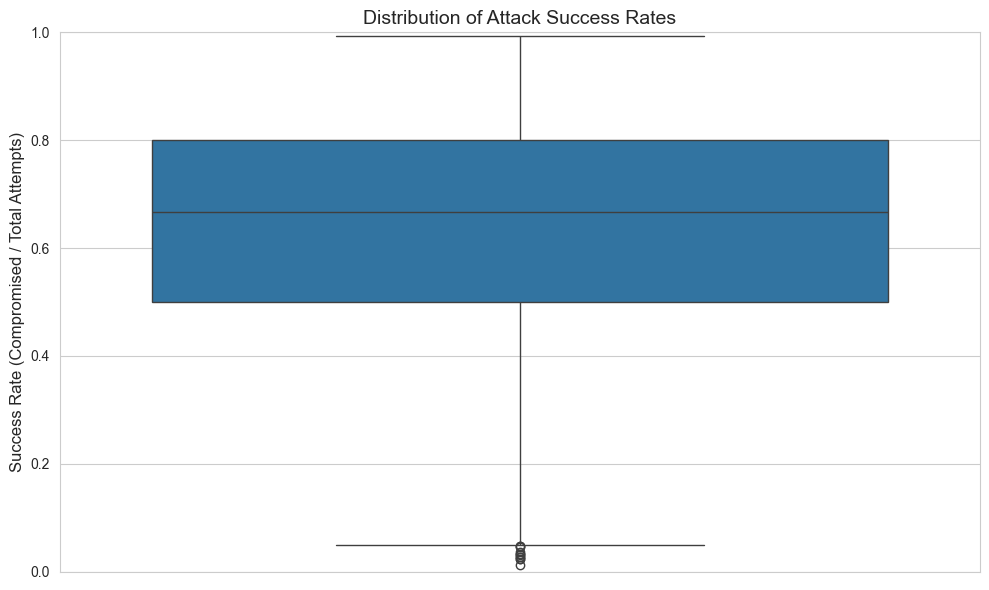

In [16]:
# Figure 5: attack success rate box plot
compromised_users = df[(((df['Is Attack IP'] == True) & (df['Login Successful'] == True)) | (df['Is Account Takeover'] == True))]

# for each compromised user, count the number of compromised instances
compromised_instances = compromised_users.groupby('User ID').size().reset_index(name='Compromised Instances')

compromised_users = compromised_users.merge(
    compromised_instances,
    on='User ID',
    how='left'
)

# for each compromised user, count the number of login attempts in attacked_df
login_attempts_per_user = attacked_df.groupby('User ID').size().reset_index(name='Total Malicious Attempts')

compromised_users = compromised_users.merge(
    login_attempts_per_user,
    on='User ID',
    how='left'
)

compromised_users['Total Malicious Attempts'] = compromised_users['Total Malicious Attempts'].fillna(0).astype(int)

compromised_users = compromised_users[compromised_users['Total Malicious Attempts'] > 1]
compromised_users['Attack Success Rate'] = compromised_users['Compromised Instances'] / compromised_users['Total Malicious Attempts']

# drop attack success rate as this represent a previously compromised account
compromised_users = compromised_users[compromised_users['Attack Success Rate'] < 1]
compromised_users = compromised_users[compromised_users['Attack Success Rate'] > 0]

sns.set_style("whitegrid")

# Figure 5: Boxplot of Attack Success Rate
plt.figure(figsize=(10, 6))
sns.boxplot(y=compromised_users['Attack Success Rate'])
plt.title('Distribution of Attack Success Rates', fontsize=14)
plt.ylabel('Success Rate (Compromised / Total Attempts)', fontsize=12)
plt.ylim(0, 1) 
plt.tight_layout()
plt.savefig('attack_success_rate_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\701094759.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_volume = compromised_users.groupby('Attempt Volume')['Attack Success Rate'].mean()


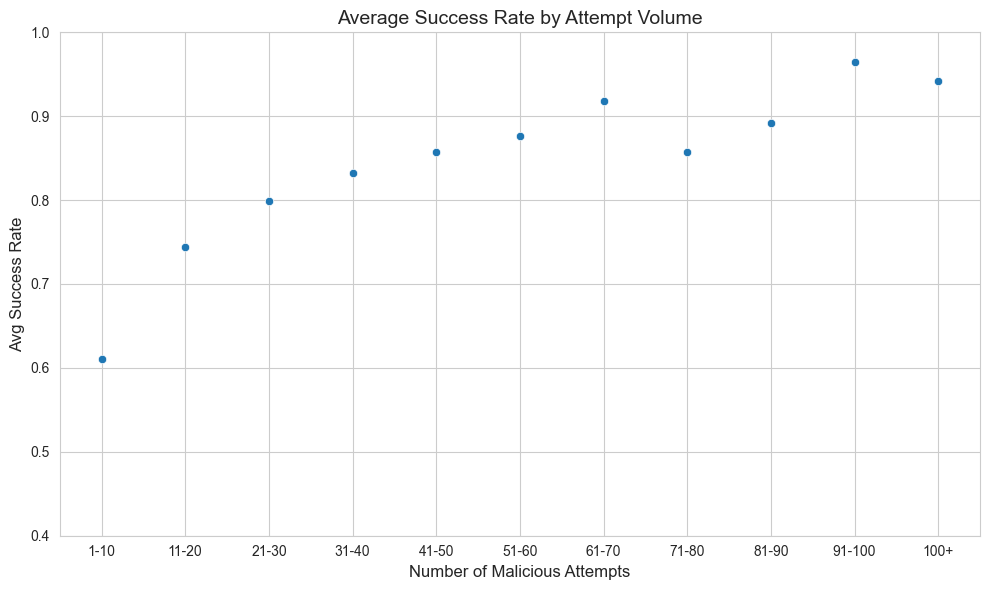

In [17]:
# Figure 6: Success Rate by Attempt Volume Scatter Plot
# Create attempt volume categories
compromised_users['Attempt Volume'] = pd.cut(
    compromised_users['Total Malicious Attempts'],
    bins=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')],
    labels=['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100+']
)

# Calculate mean success rate by volume category
success_by_volume = compromised_users.groupby('Attempt Volume')['Attack Success Rate'].mean()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=success_by_volume.index, y=success_by_volume.values)
plt.title('Average Success Rate by Attempt Volume', fontsize=14)
plt.xlabel('Number of Malicious Attempts', fontsize=12)
plt.ylabel('Avg Success Rate', fontsize=12)
plt.ylim(0.4, 1) 
plt.tight_layout()
plt.savefig('attack_success_rate_by_attempt_volume.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\Derek\AppData\Local\Temp\ipykernel_23352\3728489062.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_by_volume = compromised_users.groupby('Attempt Volume')['Attack Success Rate'].mean()


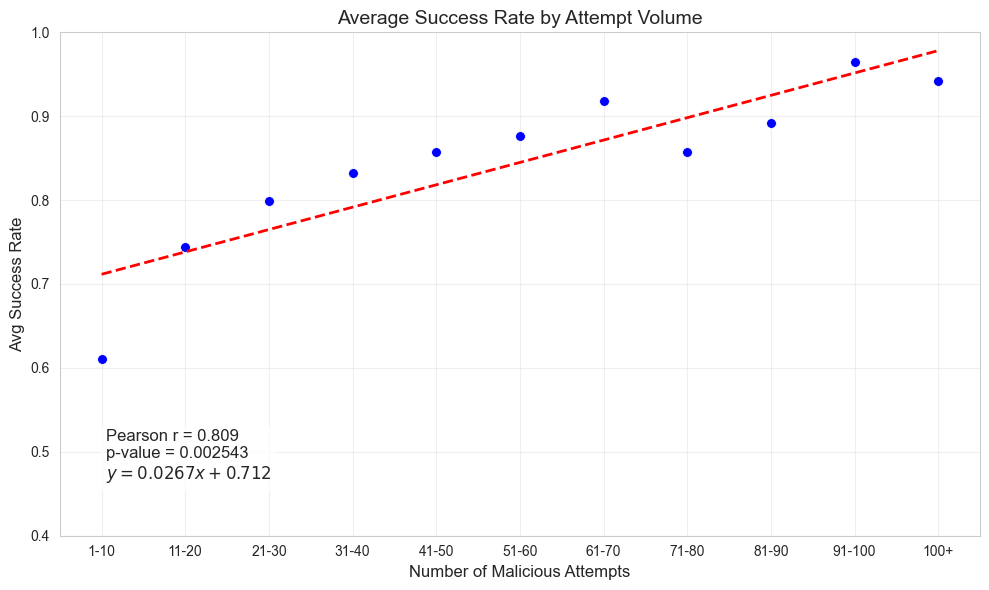

In [18]:
# Figure 7: Success Rate by Attempt Volume Correlation
# Create attempt volume categories
compromised_users['Attempt Volume'] = pd.cut(
    compromised_users['Total Malicious Attempts'],
    bins=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, float('inf')],
    labels=['1-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '100+']
)

# calculate mean success rate by volume category
success_by_volume = compromised_users.groupby('Attempt Volume')['Attack Success Rate'].mean()

# create a new figure
plt.figure(figsize=(10, 6))

# Calculate midpoints for the attempt volume categories for correlation calculation
midpoints = []
for category in success_by_volume.index:
    if category == '100+':
        midpoints.append(150)  # Approximation for open-ended category
    else:
        low, high = map(int, category.split('-'))
        midpoints.append((low + high) / 2)

# Calculate Pearson correlation using the midpoints
correlation, p_value = stats.pearsonr(midpoints, success_by_volume.values)

# Create the scatter plot
sns.scatterplot(x=success_by_volume.index, y=success_by_volume.values, color='blue', s=50)

# Add trendline 
x_pos = np.arange(len(success_by_volume))
slope, intercept = np.polyfit(x_pos, success_by_volume.values, 1)
plt.plot(x_pos, slope * x_pos + intercept, 'r--', linewidth=2)

# Add correlation statistics and formula
plt.text(0.05, 0.10, 
         f"Pearson r = {correlation:.3f}\np-value = {p_value:.6f}\n$y = {slope:.4f}x + {intercept:.3f}$",
         transform=plt.gca().transAxes, 
         fontsize=12, 
         verticalalignment='bottom',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Average Success Rate by Attempt Volume', fontsize=14)
plt.xlabel('Number of Malicious Attempts', fontsize=12)
plt.ylabel('Avg Success Rate', fontsize=12)
plt.ylim(0.4, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('attack_success_rate_by_attempt_volume_correlation.png', dpi=300, bbox_inches='tight')
plt.show()